## Walrus coder vs. Arithmetic coder Efficiency Comparisons

### Empirical tests using `test1_12.out`

Testing 12-bit versions of both coders.  Each test is run with p_A held constant, and pseudorandom input data matching that p_A, until the entropy of the input data is 10000 bits.  For a given p_A, the same pseudorandom input is fed to each coder.  Tests are run with p_A's from 2<sup>-1</sup> down to 2<sup>-16</sup>.

In [12]:
import matplotlib.pyplot as plt
import re

def parse_test_line(line):
    fields = line.rstrip().split()
    try:
        fields[0] = float(fields[0])
        fields[1] = int(fields[1])
        fields[2] = float(fields[2])
        fields[3] = int(fields[3])
        assert fields[4] in ["Yes", "No"]
        fields[4] = (fields[4] == "Yes")
    except:
        return None
    return fields

def parse_test_label(line):
    m = re.match(r"..*\((.*)\)", line)
    if m:
        return m.group(1)
    else:
        return None

def read_test(f):
    line = f.readline()
    while not parse_test_label(line):
        line = f.readline()
        if line == "":
            raise Exception("end of file")
    label = parse_test_label(line)

    while not parse_test_line(line):
        line = f.readline()
        if line == "":
            raise Exception("end of file")
    entries = []
    while parse_test_line(line):
        entries.append(parse_test_line(line))
        line = f.readline()
        if line == "":
            break
    return label, entries
        
def plot_tests(filename, colors, limit=None, alpha=1.0, linewidth=1):
    y_lim = 0
    
    f = open(filename)
    for color in colors:
        xs = []
        ys = []
        label, entries = read_test(f)
        for lg_p_A, n_sym, n_bits_ideal, n_bits_actual, does_match in entries:
            if limit != None and lg_p_A < limit:
                break
                
            x = -lg_p_A
            y = 100.0 * n_bits_ideal / n_bits_actual
            if y < y_lim:
                x_prev, y_prev = xs[-2], ys[-2]
                frac = (y_lim - y_prev) / (y - y_prev)
                xs.append(x_prev + frac * (x - x_prev))
                ys.append(y_prev + frac * (y - y_prev))
                break
                
            xs.append(x)
            ys.append(y)
        plt.plot(xs, ys, color, label=(label + " (12-bit)"),
                 alpha=alpha, linewidth=linewidth)
        plt.xlabel("- lg ( p_A )")
        plt.ylabel("coding efficiency (%)")
        plt.legend(loc="lower left", framealpha=0.5)
    plt.show()

The red "Old_Arith_coder" line below shows the performance of Arithmetic_coder without its `avoid_straddle` feature.  The blue line shows its performance with the feature.  Note that most of the difference happens when lg(p_A) <= -12, the nominal resolution of the coders being tested.  After that point the green (walrus) and blue (new arithmetic) lines are identical.

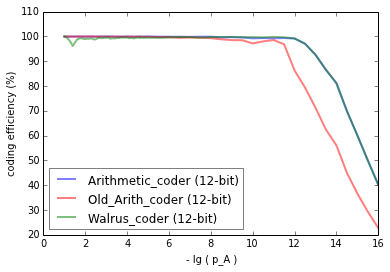

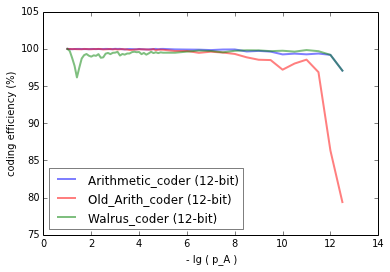

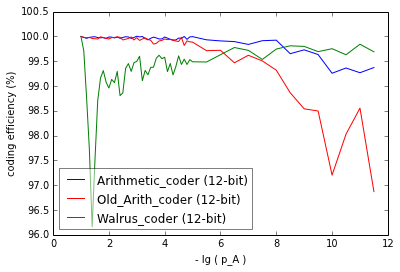

In [13]:
plot_tests("test1_12.out", ["b", "r", "g"], alpha=0.5, linewidth=2)
plot_tests("test1_12.out", ["b", "r", "g"], limit=-12.5, 
           alpha=0.5, linewidth=2)
plot_tests("test1_12.out", ["b", "r", "g"], limit=-11.5)

### Generating Markov models for constant p_A

With a slightly simplified (and slightly less efficient) "pessimistic" picture of how the Walrus coder works, it's easy to build a Markov model to give expected and lower-bound efficiencies.  In this pessimistic picture, the state_width identifies the state.  There can be more than one transition between the same in and out state.  

#### Transition table format 

At this stage it's a list of transition tuples.  Nothing is guaranteed about the order of the list:

    [
      (in_state_width, probability, out_state_width, n_of_bits_out),
      ...
    ]
    


In [3]:
from walrus_piece import *

def transitions_const_p_A(coder_nbits, p_A):
    assert p_A <= .5
    
    max_width = 1 << coder_nbits
    ip_A = int(p_A * P_A_STOP + .5)
    # undone and done are sets of state-widths
    undone = set([max_width])
    done = set()
    transitions = []
    while undone:
        width = undone.pop()
        short_i = 0
        while (max_width >> short_i) > width:
            short_i += 1
        walrus_len, w, e = choose_walrus_len(ip_A, "A", "B", 
                                         coder_nbits, width, short_i)
        walrus_width = max_width >> walrus_len
        if w == "A":
            walrus_prob, eggman_prob = p_A, 1.0 - p_A
        else:
            walrus_prob, eggman_prob = 1.0 - p_A, p_A
        out_states = set()
        # Walrus transition
        transitions.append( (width, walrus_prob, max_width,
                             walrus_len) )
        out_states.add(max_width)
        # Eggman transition
        #     If and only if the eggman after_width is a power of two,
        #     the pessimistic walrus shifts up and transitions to the
        #     start state (max_width).
        after_width = width - walrus_width
        for i in range(short_i, coder_nbits + 1):
            if after_width == max_width >> i:
                transitions.append( (width, eggman_prob, max_width, i) )
                out_states.add(max_width)  # Unnecessary, really.
                break
        else:
            assert after_width > 1, (width, walrus_len, after_width, short_i)
            transitions.append( (width, eggman_prob, 
                                 after_width, 0) )
            out_states.add(after_width)
        done.add(width)
        for out_state in out_states:
            if out_state not in done:
                undone.add(out_state)
    return transitions

print transitions_const_p_A(12, .5)
print
print transitions_const_p_A(12, .376)
print
print transitions_const_p_A(12, .374)
print
print transitions_const_p_A(12, .25)
print


[(4096, 0.5, 4096, 1), (4096, 0.5, 4096, 1)]

[(4096, 0.624, 4096, 1), (4096, 0.376, 4096, 1)]

[(4096, 0.374, 4096, 2), (4096, 0.626, 3072, 0), (3072, 0.626, 4096, 1), (3072, 0.374, 4096, 2)]

[(4096, 0.25, 4096, 2), (4096, 0.75, 3072, 0), (3072, 0.75, 4096, 1), (3072, 0.25, 4096, 2)]



### From transitions to loops

With the pessimistic picture and a fixed `p_A`, the transitions that are not to the start state form a tree (with the start state at the root).  Each transition back to start is the end of a message or "loop" from start to start.  The transitions need to be sorted, and then all the loops can be found, and for each,

* the number of symbols in the message
* The probability and entropy of the message
* the number of coded bits
    
These allow easy calculation of the coding efficiency for each loop, and the expected coding efficiency for the pessimistic picture as a whole with the given fixed `p_A`.  The worst-case efficiency for `p_A` is that of the worst loop.  Below the tables of numbers is a section where they're graphed.

In [4]:
from collections import Counter, defaultdict
from math import log # fer chrissakes.

def trans_tree_to_loops(transitions):
    """
    transitions is a list
        [
            (in_state, prob, out_state, n_bits),
             ...
        ]
    The higher states in the tree have higher numbers.
    Output is a list of one tuple per loop
        [
            (probability, n_syms, n_bits),
            ...
        ]
    """
    state_trans = defaultdict(list)
    for in_state, p, o, n in transitions:
        state_trans[in_state].append( (p, o, n) )
    states = list(state_trans.keys())
    start_state = max(states)
    
    # Check that transitions are tree-like except going back to start.
    n_trans_to = Counter(out for (i, p, out, n) in transitions)
    assert len(state_trans) == len(n_trans_to)
    assert all(n_trans_to[state] == 1 for state in states 
               if state != start_state)
    
    loops = []
    # state_info values are tuples (in_state, prob, n_syms, n_bits)
    state_info = set([ (start_state, 1.0, 0, 0) ])
    while state_info:
        in_state, in_prob, in_n_syms, in_n_bits = state_info.pop()
        for tran_prob, out_state, tran_n_bits in state_trans[in_state]:
            prob = in_prob * tran_prob
            n_syms = in_n_syms + 1
            n_bits = in_n_bits + tran_n_bits
            if out_state == start_state:
                loops.append( (prob, n_syms, n_bits) )
            else:
                state_info.add( (out_state, prob, n_syms, n_bits) )
    return loops

def loops_demo(p_A, coder_nbits=12):
    """
    Print a table of loops for the given p_A.
    """
    trans = transitions_const_p_A(coder_nbits, p_A)
    loops = trans_tree_to_loops(trans)
    print "Loops for fixed p_A ==", p_A
    fmt1 = "%8f  |%6d  |  %4i  %8f  |  %8.5f  %8f"
    fmt2 = "%8f  |%6s  |  %4s  %8f  |  %8s  %8f"
    fmt0 = "%8s  |%6s  |  %4s  %8s  |  %8s  %8s"
    print fmt0 % ("", "syms", "bits", "", "", "")
    print fmt0 % ("prob", "in ", "out", "weighted", "entropy", "weighted")
    horiz_line = "----------+--------+------------------+--------------------"
    print horiz_line
    weighted_n_bits = 0.0
    weighted_entropy = 0.0
    total_prob = 0.0
    worst_effish = 1.0
    for prob, n_syms, n_bits in loops:
        entropy = -log(prob, 2)
        print fmt1 % (prob, n_syms, n_bits, prob * n_bits, entropy, prob * entropy)
        weighted_n_bits += prob * n_bits
        weighted_entropy += prob * entropy
        worst_effish = min(worst_effish, entropy / n_bits)
        total_prob += prob
    print horiz_line
    print fmt2 % (total_prob, "", "", weighted_n_bits, "", weighted_entropy)
    print 
    print "expected efficiency:", weighted_entropy / weighted_n_bits
    print "worst-case efficiency:", worst_effish
    
loops_demo(.376)
print

loops_demo(.374)
print

loops_demo(.333)
print

loops_demo(.26)
print

loops_demo(.24)
print

loops_demo(.125)
print

Loops for fixed p_A == 0.376
          |  syms  |  bits            |                    
    prob  |   in   |   out  weighted  |   entropy  weighted
----------+--------+------------------+--------------------
0.624000  |     1  |     1  0.624000  |   0.68038  0.424558
0.376000  |     1  |     1  0.376000  |   1.41120  0.530609
----------+--------+------------------+--------------------
1.000000  |        |        1.000000  |            0.955168

expected efficiency: 0.955167891861
worst-case efficiency: 0.6803820658

Loops for fixed p_A == 0.374
          |  syms  |  bits            |                    
    prob  |   in   |   out  weighted  |   entropy  weighted
----------+--------+------------------+--------------------
0.374000  |     1  |     2  0.748000  |   1.41889  0.530665
0.391876  |     2  |     1  0.391876  |   1.35153  0.529633
0.234124  |     2  |     2  0.468248  |   2.09466  0.490409
----------+--------+------------------+--------------------
1.000000  |        |        

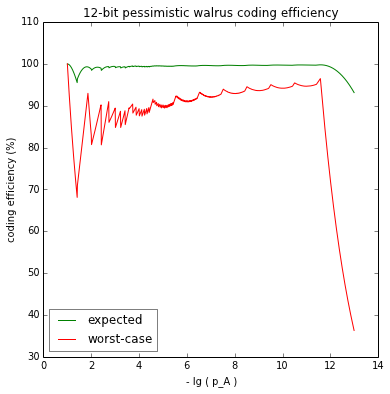

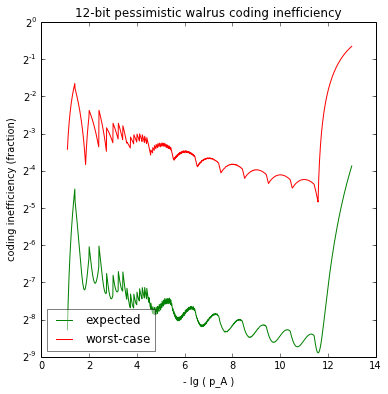

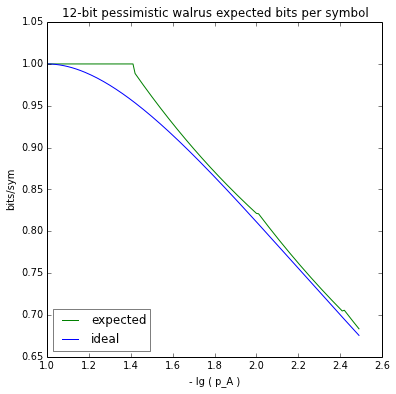

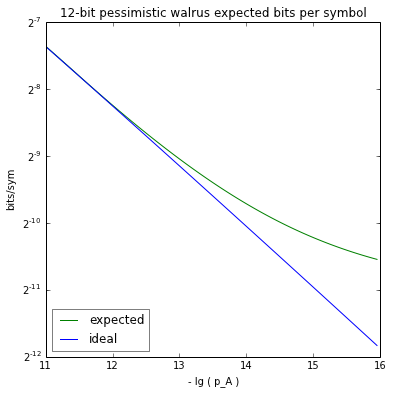

In [7]:
def loops_performance(loops):
    """ 
    Returns expected efficiency, worst-case efficiency, 
    and expected bits/symbol.
    """
    weighted_n_bits = 0.0
    weighted_entropy = 0.0
    weighted_n_syms = 0.0
    worst_effish = 1.0
    worst_bits_per_sym = 0.0
    for (prob, n_syms, n_bits) in loops:
        entropy = -log(prob, 2)
        weighted_n_bits += prob * n_bits
        weighted_entropy += prob * entropy
        weighted_n_syms += prob * n_syms
        worst_effish = min(worst_effish, entropy / n_bits)
        worst_bits_per_sym = max(worst_bits_per_sym,
                                 n_bits / n_syms)
    return (weighted_entropy / weighted_n_bits, worst_effish, 
            weighted_n_bits / weighted_n_syms)

def performance_graph(graph_type, coder_nbits=12,
                      x_axis_type="log", y_axis_type="linear",
                      lg_p_A_start=-1.0, lg_p_A_stop=-4.0,
                      lg_p_A_step=-.01):
    if graph_type == "bits/sym":
        title = "%d-bit pessimistic walrus expected bits per symbol" % coder_nbits
        ylabel = "bits/sym"
    elif graph_type == "efficiency":
        title = "%d-bit pessimistic walrus coding efficiency" % coder_nbits
        ylabel = "coding efficiency (%)"
    elif graph_type == "inefficiency":
        title = "%d-bit pessimistic walrus coding inefficiency" % coder_nbits
        ylabel = "coding inefficiency (fraction)"        
    else:
        raise ValueError(str(graph_type) + " isn't a valid graph_type")
    
    plt.figure(figsize=(6, 6), dpi=75)
    xs = []
    ys = []
    ys_worst = []
    ys_ideal = []
    for lg_p_A in arange(lg_p_A_start, lg_p_A_stop, lg_p_A_step):
        p_A = 2 ** lg_p_A
        trans = transitions_const_p_A(coder_nbits, p_A)
        loops = trans_tree_to_loops(trans)
        expected_effish, worst_effish, expected_bits_per_sym = \
            loops_performance(loops)
                
        # Either remember y(s) and x, or skip (continue):
        if graph_type == "bits/sym":
            ys.append(expected_bits_per_sym)
            ys_ideal.append(-log(p_A, 2) * p_A \
                            - log(1 - p_A, 2) * (1 - p_A))
        elif graph_type == "efficiency":
            ys.append(100.0 * expected_effish)
            ys_worst.append(100.0 * worst_effish)
        elif graph_type == "inefficiency":
            if expected_effish == 1.0:
                continue
                
            ys.append(1.0 - expected_effish)
            ys_worst.append(1.0 - worst_effish)
        else:
            raise ValueError(str(graph_type) + " isn't a valid graph_type")

        # (If we get to this point) remember the x.
        if x_axis_type == "log":
            xs.append(-lg_p_A)
        else:
            xs.append(p_A)
            
    plt.title(title)
    if x_axis_type == "log":
        plt.xlabel("- lg ( p_A )")
    else:
        plt.xlabel("p_A")
        plt.gca().invert_xaxis()
    if y_axis_type == "log":
        plt.yscale("log", basey=2)
    else:
        plt.yscale("linear")
        
    ymax = max(ys)
    plt.plot(xs[:1], [ymax * 1.02], "w")

    plt.ylabel(ylabel)
    plt.plot(xs, ys, "g", label="expected")
    if ys_worst:
        plt.plot(xs, ys_worst, "r", label="worst-case")
        plt.legend(loc="lower left", framealpha=0.5)
    if ys_ideal:
        plt.plot(xs, ys_ideal, "b", label="ideal")
        plt.legend(loc="lower left", framealpha=0.5)
    plt.show()

# performance_graph("bits/sym", coder_nbits=4,
#                   lg_p_A_stop=-6.0, lg_p_A_step=-.05, 
#                   x_axis_type="log", y_axis_type="log")
performance_graph("efficiency", lg_p_A_stop=-13.0)
performance_graph("inefficiency", lg_p_A_start=-1.1, lg_p_A_stop=-13.0, 
                  y_axis_type="log")
# performance_graph("efficiency", lg_p_A_start=-1.0, lg_p_A_stop=-5.0,
#                   lg_p_A_step=-.002, x_axis_type="log")
performance_graph("bits/sym", lg_p_A_stop=-2.5, y_axis_type="linear")
performance_graph("bits/sym", lg_p_A_start=-11.0, lg_p_A_stop=-16.0,
                  lg_p_A_step=-.05, 
                  x_axis_type="log", y_axis_type="log")